# <p style="text-align: center;"> Charter school identities and outcomes in the accountability era:<br/> Preliminary results
<p style="text-align: center;">April 19th, 2017<br/>By Jaren Haber, PhD Candidate<break/>Dept. of Sociology, UC Berkeley

<p style="text-align: center;">![alt text](http://jaypgreene.files.wordpress.com/2009/12/explosion_600x625600x625.jpg "Old U.S. Map of charter schools by state")
<p style="text-align: center;">(this out-dated graphic courtesy of U.S. News & World Report, 2009)

## Research questions
**How are charter schools different from each other in terms of ideology? How do these differences shape their survival and their outcomes, and what does this reveal about current educational policy?** 

## The corpus
- Website self-descriptions of all **6,753 charter schools** open in 2014-15 (identified using the NCES Public School Universe Survey)
- Charter school websites are a publicly visible proclamation of identity attempting to impress parents, regulators, etc.
- This study the first to use this contemporary, comprehensive data source on U.S. charter school identities
- Me & research team working on using BeautifulSoup and requests.get to webscrape the full sample

### Motivation
- Too much focus on test scores in education, too little on organizational aspects
- Are charter schools innovative? How?
- How does educational policy shape ed. philosophy? Organization? Outcomes?
- No one has studied charters' public image as expressed in their OWN words

### Methods
- NLP: Word frequencies, distinctive words, etc.
- Supervised: Custom dictionaries
- Unsupervised: Topic models, word embeddings
- Later: statistical regression to test, e.g., how progressivist schools in liberal communities have higher performance than they do in other places

## Preliminary analysis: website self-descriptions of non-random sample of 196 schools
- Early-stage sample: NOT representative!
- About half randomly selected, half tracked down (many through Internet Archive) because of missing URLs
- Closed schools over-represented

## Preliminary conclusions: 
### Word counts:
- Website self-descriptions for schools in mid-sized cities and suburbs tend to be longest, followed by other urban and suburban schools, then schools in towns, and shortest tends to be rural schools
- Charter schools in cities and suburbs have the highest textual redundancy (lowest ratio of types to tokens)

### Word embeddings:
- The two educational philosophies I'm interested in--**progressivism** and **essentialism**--can be distinguished using semantic vectors
- Useful way for creating and checking my dictionaries

### Topic modeling:
- Urban charter schools' websites emphasize **GOALS** (topic 0)
- Suburban charter schools' websites emphasize **CURRICULUM** (topic 1) in addition to goals

## Next steps:
- Working with custom dictionaries, POS tagging
- Webscraping and parsing HTML to get full sample
- Match website text with data on test scores and community characteristics (e.g., race, class, political leanings) --> test hypotheses with statistical regression<br/><br/>
- **More long-term**: Collect longitudinal mission statement data from the Internet Archive --> look at survival and geographic dispersion of identity categories over time (especially pre-NCLB if possible)

In [25]:
# The keyword categories to help parse website text:
mission = ['mission',' vision ', 'vision:', 'mission:', 'our purpose', 'our ideals', 'ideals:', 'our cause', 'cause:', 'goals', 'objective']
curriculum = ['curriculum', 'curricular', 'program', 'method', 'pedagogy', 'pedagogical', 'approach', 'model', 'system', 'structure']
philosophy = ['philosophy', 'philosophical', 'beliefs', 'believe', 'principles', 'creed', 'credo', 'value',  'moral']
history = ['history', 'our story', 'the story', 'school story', 'background', 'founding', 'founded', 'established', 'establishment', 'our school began', 'we began', 'doors opened', 'school opened']
general =  ['about us', 'our school', 'who we are', 'overview', 'general information', 'our identity', 'profile', 'highlights']

## Initializing Python

In [26]:
#!/usr/bin/env python
# -*- coding: UTF-8

In [27]:
# IMPORTING KEY PACKAGES
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas # for working with dataframes
import numpy as np # for working with numbers

In [28]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # an approximate method of stemming words (it just cuts off the ends)
from nltk.corpus import stopwords # for one method of eliminating stop words, to clean the text
stopenglish = list(stopwords.words("english")) # assign the string of english stopwords to a variable and turn it into a list
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign the string of common punctuation symbols to a variable and turn it into a list

In [29]:
# FOR ANALYZING WITH THE TEXT
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

import gensim # for word embedding models
from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

In [30]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/bradafzali/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Reading in preliminary data

In [31]:
sample = [] # make empty list
with open('micro-sample_2013.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        sample.append(row) # append each row to the list

# Also read in output.csv, to get newly parsed webtext
new_output = [] # make empty list
with open('output.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        new_output.append(row) # append each row to the list

In [32]:
sample[0]

OrderedDict([('LEANM', 'RICHLAND 02'),
             ('SEARCH',
              'RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, COLUMBIA, SC'),
             ('CER_NAME', 'Richland Two Charter High School'),
             ('URL', 'https://www.richland2.org/charterhigh/'),
             ('ADDRESS', '750 OLD CLEMSON RD, COLUMBIA, SC'),
             ('SCHOOL ID', 'SC600'),
             ('LEVEL', '3'),
             ('YEAR_OPEN_CER', '2010'),
             ('CER_MS_2012',
              'Flexible schedule allows students to work and explore different careers while receiving their high school diploma.'),
             ('SURVYEAR', '2013'),
             ('NCESSCH', '4.50E+11'),
             ('FIPST', '45'),
             ('LEAID', '4503390'),
             ('SCHNO', '1554'),
             ('STID', '4002'),
             ('SEASCH', '600'),
             ('SCHNAM', 'RICHLAND TWO CHARTER HIGH'),
             ('PHONE', '8034191348'),
             ('MSTREE', '750 OLD CLEMSON ROAD'),
             ('MCITY', 'COLUM

In [33]:
new_output[0]

OrderedDict([('SEARCH',
              'Richland Two Charter High 750 Old Clemson Road, Columbia, SC 29229'),
             ('MANUAL_URL', 'https://www.richland2.org/charterhigh/'),
             ('OLD_URL', 'https://www.richland2.org/charterhigh'),
             ('ADDRESS', '750 Old Clemson Road, Columbia, SC 29229'),
             ('STABR', 'SC'),
             ('NCESSCH', '450339001554'),
             ('SCH_NAME', 'Richland Two Charter High'),
             ('folder_name', '001 Richland Two Charter High'),
             ('parsed_files',
              "['/Users/bradafzali/research/text_analysis/wget_sept8/001 Richland Two Charter High/www.richland2.org/charterhigh/index.html']"),
             ('alltext',
              '2016 Richland Two Career Pathways Expo Richland School District Two will be hosting a Career Pathways Expo on Thursday, October 27 from 3:00 pm to 7:00 pm at the newest facility, R2i2 (behind the Village at Sandhill). All students in grades 7-12 along with their parents/and or

In [34]:
# First initialize every school's WEBTEXT value
for s in sample:
    s["WEBTEXT"] = ""

# For every school in which we have parsed html, use string matching to find
# the matching school in micro-sample_2013.csv
for output in new_output:
    index = 0
    for s in sample:
        if s["SCHNAM"].lower() == output["SCH_NAME"].lower():
            break
        index += 1
    # If index is 300, then the school name from output.csv was not found in micro-sample_2013.csv
    if index != 300:
        sample[index]["WEBTEXT"] = output["alltext"]

# Write the merged list of ordered dicts to merged.csv
with open('merged.csv', 'w', newline='') as csvfile:
    fieldnames = list(sample[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for s in sample:
        writer.writerow(s)

In [35]:
# Take a look at the most important contents and the variables list
# in our sample (a list of dictionaries)--let's look at just the first entry
print(sample[1]["SCHNAM"], "\n", sample[1]["URL"], "\n", sample[1]["WEBTEXT"], "\n")
print(sample[1].keys()) # look at all the variables!

POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 
 https://www.polk.edu/lakeland-gateway-to-college-high-school/ 
 Back to Polk.edu Search the Polk State network Financial Aid Guaranteed Processing Deadline is December 1, 2016 Tuesday, 11/01/16 - Thursday, 12/01/16 Polk State College Thanksgiving Break (College Closed â No Saturday Classes on 11/26/16) Wednesday, 11/23/16 - Sunday, 11/27/16 Last Faculty Work Day Wednesday, 12/14/16 - All Day Graduation Wednesday, 12/14/16 | 6:30 PM - 8:00 PM The Lakeland Center, 701 Lime St, Lakeland Polk State Lakeland Gateway to College Collegiate High School is an exciting new opportunity for area students, typically between the ages of 16 and 21, who have earned 45% of the credits required for high school graduation. All courses are taught on the Polk State Lakeland campus and offered during morning and afternoon hours, to provide students with maximum flexibility and opportunity for success. The school is funded in part through a grant from the Gateway

In [36]:
# Read the newly merged data in as a pandas dataframe
df = pandas.read_csv("merged.csv", encoding = 'Latin-1')
df = df.dropna(subset=["WEBTEXT"]) # drop any schools with no webtext that might have snuck in (none currently)

In [37]:
# Add additional variables for analysis:
# PCTETH = percentage of enrolled students belonging to a racial minority
# this includes American Indian, Asian, Hispanic, Black, Hawaiian, or Pacific Islander
df["PCTETH"] = (df["AM"] + df["ASIAN"] + df["HISP"] + df["BLACK"] + df["PACIFIC"]) / df["MEMBER"]

df["STR"] = df["MEMBER"] / df["FTE"] # Student/teacher ratio
df["PCTFRPL"] = df["TOTFRL"] / df["MEMBER"] # Percent of students receiving FRPL

# Another interesting variable: 
# TYPE = type of school, where 1 = regular, 2 = special ed, 3 = vocational, 4 = other/alternative, 5 = reportable program

In [38]:
## Print the webtext from the first school in the dataframe
print(df.iloc[2]["WEBTEXT"])

River City Scholars is a free public charter school serving young-five kindergarten through 8th grade. Seats are filling fast, so apply today ! Founded on academic excellence, moral focus, parental partnership, and student responsibility, River City Scholars is a school like no other Ã¢ÂÂone that can lead to a lifetime of success. We provide a safe learning environment and our exceptional teachers individualize instruction based on your childÃ¢ÂÂs needs. In addition, we focus on real-world skills and how to be a good person. Our students also draft a social contract that reinforces their commitment to their school, their teacher, and each other. If you would like to schedule a school tour to learn more about our academic program, Moral Focus curriculum, and school environment, please feel free to contact us for more information. We look forward to hearing from you! Menu Call Map Login Search At the School Calendar Before-After School School Meals Extracurriculars Photo Gallery Dres

## Descriptive statistics

### How urban proximity is coded: Lower number = more urban (closer to large city) 

More specifically, it uses two digits with distinct meanings: 
- the first digit: 
    - 1 = city
    - 2 = suburb
    - 3 = town
    - 4 = rural
- the second digit:
    - 1 = large or fringe
    - 2 = mid-size or distant
    - 3 = small/remote

In [39]:
print(df.describe()) # get descriptive statistics for all numerical columns
print()
print(df['ULOCAL'].value_counts()) # frequency counts for categorical data
print()
print(df['LEVEL'].value_counts()) # treat grade range served as categorical
# Codes for level/ grade range served: 3 = High school, 2 = Middle school, 1 = Elementary, 4 = Other)
print()
print(df['LSTATE'].mode()) # find the most common state represented in these data
print(df['ULOCAL'].mode()) # find the most urbanicity represented in these data
# print(df['FTE']).mean() # What's the average number of full-time employees by school?
# print(df['STR']).mean() # And the average student-teacher ratio?

       YEAR_OPEN_CER  SURVYEAR       NCESSCH       FIPST         LEAID  \
count     199.000000     239.0  2.390000e+02  239.000000  2.390000e+02   
mean     2004.834171    2013.0  2.470251e+11   24.635983  2.470628e+06   
std         5.026961       0.0  1.710359e+11   17.151491  1.710624e+06   
min      1992.000000    2013.0  4.000610e+10    4.000000  4.000610e+05   
25%      2001.000000    2013.0  6.350651e+10    6.000000  6.350650e+05   
50%      2005.000000    2013.0  2.500000e+11   25.000000  2.500519e+06   
75%      2009.500000    2013.0  3.900000e+11   39.000000  3.901528e+06   
max      2012.000000    2013.0  5.510000e+11   55.000000  5.513650e+06   

              SCHNO         PHONE          MZIP        MZIP4          LZIP  \
count    239.000000  2.390000e+02    239.000000   239.000000    239.000000   
mean    5247.958159  5.754307e+09  61362.916318  2143.200837  61411.368201   
std     4098.870407  2.463393e+09  28774.024480  2841.144960  28793.221525   
min       16.000000  

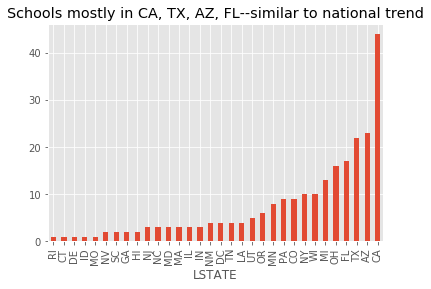

In [40]:
# here's the number of schools from each state, in a graph:
grouped_state = df.groupby('LSTATE')
grouped_state['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Schools mostly in CA, TX, AZ, FL--similar to national trend')
plt.show()

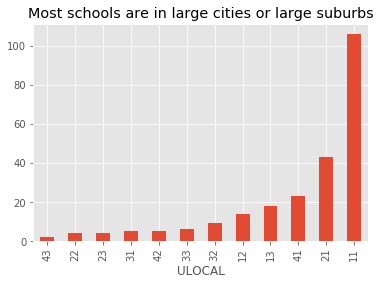

In [41]:
# and here's the number of schools in each urban category, in a graph:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Most schools are in large cities or large suburbs')
plt.show()

#### What these numbers say about the charter schools in the sample:
- Most are located in large cities, followed by large suburbs, then medium and small city, and then rural.
- The means for percent minorities and students receiving free- or reduced-price lunch are both about 60%.
- Most are in CA, TX, AZ, and FL
- Most of the schools in the sample are primary schools

#### This means that the sample reflects national averages. In that sense, this sample isn't so bad.

## Cleaning, tokenizing, and stemming the text

In [42]:
# Now we clean the webtext by rendering each word lower-case then removing punctuation. 
df['webtext_lc'] = df['WEBTEXT'].str.lower() # make the webtext lower case
df['webtokens'] = df['webtext_lc'].apply(nltk.word_tokenize) # tokenize the lower-case webtext by word
df['webtokens_nopunct'] = df['webtokens'].apply(lambda x: [word for word in x if word not in list(string.punctuation)]) # remove punctuation

In [43]:
print(df.iloc[0]["webtokens"]) # the tokenized text without punctuation

['2016', 'richland', 'two', 'career', 'pathways', 'expo', 'richland', 'school', 'district', 'two', 'will', 'be', 'hosting', 'a', 'career', 'pathways', 'expo', 'on', 'thursday', ',', 'october', '27', 'from', '3:00', 'pm', 'to', '7:00', 'pm', 'at', 'the', 'newest', 'facility', ',', 'r2i2', '(', 'behind', 'the', 'village', 'at', 'sandhill', ')', '.', 'all', 'students', 'in', 'grades', '7-12', 'along', 'with', 'their', 'parents/and', 'or', 'guardians', 'are', 'invited', 'to', 'attend', '.', 'students', 'will', 'be', 'able', 'to', 'explore', 'careers', 'and', 'educational', 'opportunities', 'in', '5', 'career', 'areas', '--', 'health', 'science', ',', 'art', ',', 'stem', ',', 'business/it', ',', 'human', 'services/education', '.', 'you', 'will', 'have', 'the', 'opportunity', 'to', 'speak', 'with', 'businesses', 'and', 'educational', 'institutions', 'to', 'see', 'the', 'connection', 'of', 'what', 'you', 'are', 'learning', 'in', 'high', 'school', 'to', 'a', 'possible', 'career', '.', 'if', 'y

In [44]:
# Now we remove stopwords and stem. This will improve the results
df['webtokens_clean'] = df['webtokens_nopunct'].apply(lambda x: [word for word in x if word not in list(stopenglish)]) # remove stopwords
df['webtokens_stemmed'] = df['webtokens_clean'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

In [45]:
# Some analyses require a string version of the webtext without punctuation or numbers.
# To get this, we join together the cleaned and stemmed tokens created above, and then remove numbers and punctuation:
df['webtext_stemmed'] = df['webtokens_stemmed'].apply(lambda x: ' '.join(char for char in x))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if char not in punctuations))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

In [46]:
df['webtext_stemmed'][0]

' richland two career pathway expo richland school district two host career pathway expo thursday octob   pm  pm newest facil ri behind villag sandhil student grade  along parentsand guardian invit attend student abl explor career educ opportun  career area  health scienc art stem businessit human serviceseduc opportun speak busi educ institut see connect learn high school possibl career question pleas contact mrs holland richland  charter high school move new locat locat anna boyd school  brookmont lane columbia sc  congratul  graduat click view video ceremoni click view thevideo june   graduat ceremoni richland two charter high school brookmontlan columbiasctel  fax   ã\x82â©copyright  richland counti school district two charter high school charter high school nutrikid district offic parent portal calendar traduccion translat ã « ââ\x88ã¬â\x97â\xad home inform school board school improv council school board school improv council calendar school counsel english leadership lab hour stu

In [47]:
# Some analyses require tokenized sentences. I'll do this with the list of dictionaries.
# I'll use cleaned, tokenized sentences (with stopwords) to create both a dictionary variable and a separate list for word2vec

words_by_sentence = [] # initialize the list of tokenized sentences as an empty list
for school in sample:
    school["sent_toksclean"] = []
    school["sent_tokens"] = [word_tokenize(sentence) for sentence in sent_tokenize(school["WEBTEXT"])] 
    for sent in school["sent_tokens"]:
        school["sent_toksclean"].append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)]) # for each word: stem, lower-case, and remove punctuations
        words_by_sentence.append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)])

In [48]:
words_by_sentence[:2]

[['2016',
  'richland',
  'two',
  'career',
  'pathway',
  'expo',
  'richland',
  'school',
  'district',
  'two',
  'will',
  'be',
  'host',
  'a',
  'career',
  'pathway',
  'expo',
  'on',
  'thursday',
  'octob',
  '27',
  'from',
  '3:00',
  'pm',
  'to',
  '7:00',
  'pm',
  'at',
  'the',
  'newest',
  'facil',
  'r2i2',
  'behind',
  'the',
  'villag',
  'at',
  'sandhil'],
 ['all',
  'student',
  'in',
  'grade',
  '7-12',
  'along',
  'with',
  'their',
  'parents/and',
  'or',
  'guardian',
  'are',
  'invit',
  'to',
  'attend']]

### Counting document lengths

In [49]:
# We can also count document lengths. I'll mostly use the version with punctuation removed but including stopwords,
# because stopwords are also part of these schools' public image/ self-presentation to potential parents, regulators, etc.

df['webstem_count'] = df['webtokens_stemmed'].apply(len) # find word count without stopwords or punctuation
df['webpunct_count'] = df['webtokens_nopunct'].apply(len) # find length with stopwords still in there (but no punctuation)
df['webclean_count'] = df['webtokens_clean'].apply(len) # find word count without stopwords or punctuation

In [50]:
# For which urban status are website self-description the longest?
print(grouped_urban['webpunct_count'].mean().sort_values(ascending=False))

ULOCAL
32    2155.222222
11    1144.141509
13     950.555556
12     937.928571
41     937.043478
33     895.000000
42     839.600000
21     837.558140
31     727.800000
22     567.000000
23     517.000000
43     491.500000
Name: webpunct_count, dtype: float64


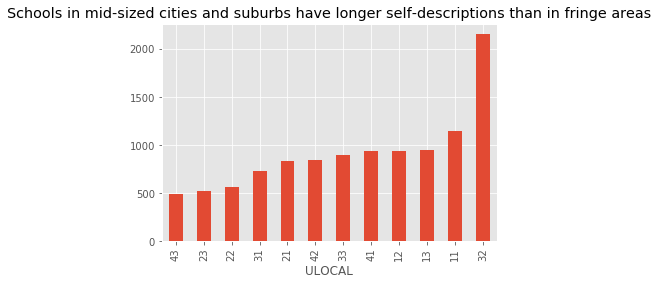

In [51]:
# here's the mean website self-description word count for schools grouped by urban proximity, in a graph:
grouped_urban['webpunct_count'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Schools in mid-sized cities and suburbs have longer self-descriptions than in fringe areas', yerr = grouped_state["webpunct_count"].std())
plt.show()

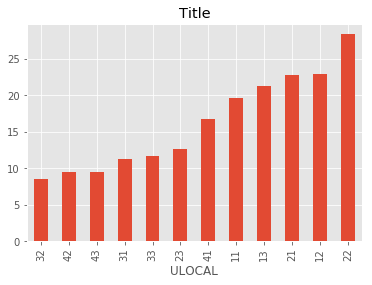

In [52]:
# Look at 'FTE' (proxy for # administrators) clustered by urban proximity and whether it explains this
grouped_urban['FTE'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Title', yerr = grouped_state["FTE"].std())
plt.show()

In [53]:
# Now let's calculate the type-token ratio (TTR) for each school, which compares
# the number of types (unique words used) with the number of words (including repetitions of words).

df['numtypes'] = df['webtokens_nopunct'].apply(lambda x: len(set(x))) # this is the number of unique words per site
df['TTR'] =  df['numtypes'] / df['webpunct_count'] # calculate TTR

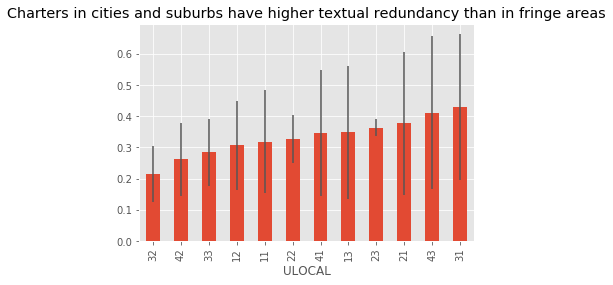

In [54]:
# here's the mean TTR for schools grouped by urban category:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['TTR'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Charters in cities and suburbs have higher textual redundancy than in fringe areas', yerr = grouped_urban["TTR"].std())
plt.show()

## (Excessively) Frequent words

In [55]:
# First, aggregate all the cleaned webtext:
webtext_all = []
df['webtokens_clean'].apply(lambda x: [webtext_all.append(word) for word in x])
webtext_all[:20]

['2016',
 'richland',
 'two',
 'career',
 'pathways',
 'expo',
 'richland',
 'school',
 'district',
 'two',
 'hosting',
 'career',
 'pathways',
 'expo',
 'thursday',
 'october',
 '27',
 '3:00',
 'pm',
 '7:00']

In [56]:
# Now apply the nltk function FreqDist to count the number of times each token occurs.
word_frequency = nltk.FreqDist(webtext_all)

#print out the 50 most frequent words using the function most_common
print(word_frequency.most_common(50))

[('school', 7976), ("''", 3893), ('elementary', 2792), ('high', 1681), ('``', 1566), ('board', 1482), ('academy', 1445), ('student', 1280), ('grade', 1209), ('calendar', 1205), ('students', 1178), ('us', 1153), ('middle', 1085), ('kipp', 1041), ('news', 997), ('staff', 988), ('parent', 949), ('2016', 908), ('education', 870), ('charter', 858), ('contact', 853), ('information', 797), ('program', 777), ('schools', 769), ('resources', 717), ('college', 674), ('0', 661), ('curriculum', 653), ('learning', 647), ('home', 619), ('community', 591), ('events', 550), ('day', 532), ('1', 519), ('enrollment', 512), ('support', 511), ('district', 501), ('mission', 491), ('parents', 488), ('var', 483), ("'s", 481), ('center', 460), ('policy', 457), ('width', 454), ('handbook', 451), ('campus', 446), ('ã¢â\x80â\x93', 432), ('lunch', 429), ('schedule', 422), ('meeting', 413)]


 ### These are prolific, ritual, empty words and will be excluded from topic models!

## Distinctive words (mostly place names)

In [57]:
sklearn_dtm = countvec.fit_transform(df['webtext_stemmed'])
print(sklearn_dtm)

  (0, 3101)	1
  (0, 401)	1
  (0, 7355)	3
  (0, 4844)	3
  (0, 9866)	6
  (0, 609)	3
  (0, 5990)	6
  (0, 9330)	2
  (0, 7970)	2
  (0, 2515)	2
  (0, 3397)	2
  (0, 3401)	2
  (0, 7018)	2
  (0, 4837)	2
  (0, 4834)	2
  (0, 4832)	2
  (0, 2396)	2
  (0, 4338)	4
  (0, 2506)	2
  (0, 8948)	2
  (0, 6950)	2
  (0, 3400)	2
  (0, 4831)	4
  (0, 9482)	2
  (0, 4398)	4
  :	:
  (238, 8888)	4
  (238, 5200)	1
  (238, 3141)	4
  (238, 4991)	5
  (238, 3535)	1
  (238, 2904)	1
  (238, 1835)	1
  (238, 9220)	3
  (238, 1152)	3
  (238, 7244)	35
  (238, 7073)	3
  (238, 8708)	1
  (238, 401)	1
  (238, 6282)	4
  (238, 967)	3
  (238, 4260)	6
  (238, 5397)	1
  (238, 6263)	1
  (238, 6072)	1
  (238, 6095)	25
  (238, 1925)	3
  (238, 513)	5
  (238, 2788)	13
  (238, 3828)	20
  (238, 7912)	14


In [58]:
# What are some of the words in the DTM? 
print(countvec.get_feature_names()[:10])

['a', 'aa', 'aae', 'aaliyah', 'aalt', 'aapa', 'aaron', 'aasc', 'aascadmin', 'aasd']


In [59]:
# now we can create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pandas.DataFrame(tfidfvec.fit_transform(df.webtext_stemmed).toarray(), columns=tfidfvec.get_feature_names(), index = df.index)

dtm_tfidf_df[:20] # let's take a look!

,aa,aae,aaliyah,aalt,aapa,aaron,aasc,aascadmin,aasd,ab,...,zuni,zupan,zweben,ân,ânistasã,âº,âºn,âºtbol,â½,ââ
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.064647
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032566,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.022646,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [60]:
# What are the 20 words with the highest TF-IDF scores?
print(dtm_tfidf_df.max().sort_values(ascending=False)[:20])

index                1.000000
rcsa                 0.912395
offlin               0.912030
kipp                 0.892925
mater                0.881315
read                 0.864592
sep                  0.849714
uplift               0.844826
pickerington         0.836631
valley               0.823624
nocc                 0.819150
mnoh                 0.809425
amp                  0.789030
elementari           0.788839
richardallenlacom    0.764864
px                   0.758422
strive               0.739365
num                  0.736510
confluenc            0.734215
magellan             0.730748
dtype: float64


### Like the frequent words above, these highly "unique" words are empty of meaning and will be excluded from topic models!

## Word Embeddings with word2vec

### Word2Vec features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

In [61]:
# train the model, using a minimum of 5 words
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=2, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

In [62]:
# dictionary of words in model (may not work for old gensim)
# print(len(model.vocab))
# model.vocab

In [63]:
# Find cosine distance between two given word vectors
# print(model.similarity('college-prep','align')) # these two are close to essentialism
# print(model.similarity('emot', 'curios')) # these two are close to progressivism

In [75]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                            'market', 'research', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'natur']

In [76]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('outstand', 0.9573196172714233), ('combin', 0.9534597396850586), ('comprehens', 0.9530351758003235), ('college-preparatori', 0.9517684578895569), ('pvcic', 0.9482283592224121), ('deliv', 0.9468422532081604), ('rigor', 0.9466230273246765), ('whole', 0.941618800163269), ('knowledg', 0.9411553144454956), ('dialogu', 0.9406280517578125)]

[('cp', 0.9472928643226624), ('bodi', 0.9402133822441101), ('option', 0.9394574165344238), ('strength', 0.9387184381484985), ('such', 0.9338828325271606), ('multipl', 0.9334657192230225), ('reflect', 0.9298487305641174), ('includ', 0.9296380281448364), ('except', 0.925805389881134), ('standards/grad', 0.9244651794433594)]


In [77]:
print(model.most_similar('emot')) # words core to progressivism

[('cp', 0.9472928643226624), ('bodi', 0.9402133822441101), ('option', 0.9394574165344238), ('strength', 0.9387184381484985), ('such', 0.9338828325271606), ('multipl', 0.9334657192230225), ('reflect', 0.9298487305641174), ('includ', 0.9296380281448364), ('except', 0.925805389881134), ('standards/grad', 0.9244651794433594)]


In [101]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
prog_words = model.most_similar(progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in progressivism:
    prog_words.append(word)
print(prog_words[:20])

['relev', 'incorpor', 'well-round', 'meaning', 'optim', 'flourish', 'dependenton', 'architect', 'rang', 'family-ori', 'energi', 'inner', 'pursuit', 'willing', 'real-lif', 'experienti', 'deliv', 'ged', 'acknowledg', 'emphas']


In [102]:
ess_words = model.most_similar(essentialism, topn=50) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

['incorpor', 'relev', 'dialogu', 'outstand', 'well-round', 'deliv', 'variou', 'civic', 'arrowhead', 'framework', 'flourish', 'proven', 'custom', 'acceler', 'experienti', 'bound', 'inclus', 'teamwork', 'aftercar', 'plu']


In [103]:
# construct an combined dictionary
phil_words = ess_words + prog_words

In [104]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('emot', word) for word in phil_words]
y = [model.similarity('align', word) for word in phil_words]

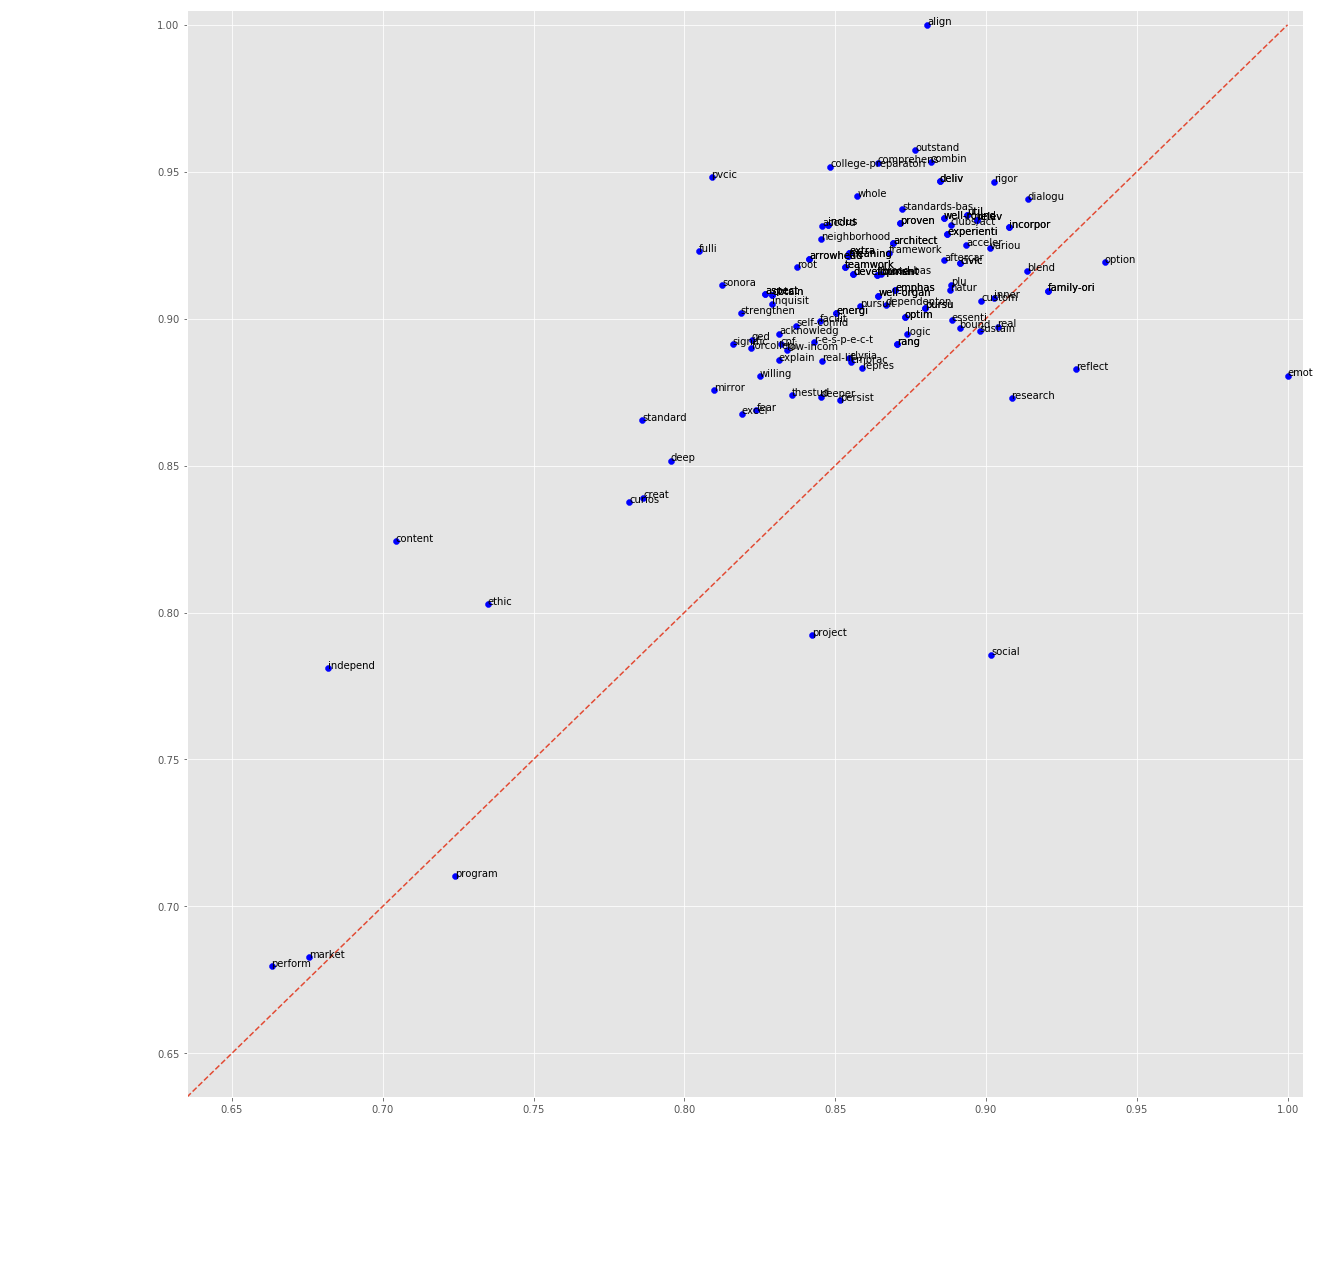

In [105]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors

## Topic Modeling with scikit-learn
> For documentation on this topic modeling (TM) package, which uses Latent Dirichlet Allocation (LDA), see [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

> And for documentation on the vectorizer package, CountVectorizer from scikit-learn, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [83]:
####Adopted From: 
#Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

# Initialize the variables needed for the topic models
n_samples = 2000
n_topics = 3
n_top_words = 50

# Create helper function that prints out the top words for each topic in a pretty way
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [86]:
# Vectorize our text using CountVectorizer
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=70, min_df=4,
                                max_features=None,
                                stop_words=stopenglish, lowercase=1
                                )

tf = tf_vectorizer.fit_transform(df.WEBTEXT)

Extracting tf features for LDA...


In [87]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

# define the lda function, with desired options
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_samples=2000 and n_topics=3...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=80.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_jobs=1, n_topics=3, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=2000, verbose=0)

In [88]:
# print the top words per topic, using the function defined above.

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
kipp 2014 2015 report san 2013 minutes meeting application preparatory september daily class enroll annual august vision mrs directors leadership form team 2012 lunch budget portal find 30 kindergarten apply athletics child collegiate first clear pm button agendas network donate schedule comments special openings bay francisco field list trip plan

Topic #1:
services center schedule lunch arts directory clubs prep family club special 10 online es girls ms 30 forms team 00 science technology sep september meeting volunteer language faculty summer grades office english 11 health supply application math room courses athletics menu meet policies valley info view email directors activities apply

Topic #2:
width slider ed height background var position button function image jpg left document jquery url top hover true opacity color http right 100 margin 400 4397552 font bottom none false length text id js read absolute 10px speed value getelementbyid overflow

These topics seem to mean:
- topic 0 relates to **GOALS**,
- topic 1 relates to **CURRICULUM**, and 
- topic 2 relates to **PHILOSOPHY** or learning process (but this topic less clear/ more mottled)

In [89]:
# Preparation for looking at distribution of topics over schools
topic_dist = lda.transform(tf) # transpose topic distribution
topic_dist_df = pandas.DataFrame(topic_dist) # turn into a df
df_w_topics = topic_dist_df.join(df) # merge with charter MS dataframe
df_w_topics[:20] # check out the merged df with topics!

,0,1,2,LEANM,SEARCH,CER_NAME,URL,ADDRESS,SCHOOL ID,LEVEL,...,webtokens,webtokens_nopunct,webtokens_clean,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR
0,0.228179,0.477074,0.294747,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",SC600,3,...,"[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathway, expo, r...",richland two career pathway expo richland sch...,599.0,818.0,599.0,190.0,0.232274
1,0.112271,0.886046,0.001684,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",FL8131,3,...,"[back, to, polk.edu, search, the, polk, state,...","[back, to, polk.edu, search, the, polk, state,...","[back, polk.edu, search, polk, state, network,...","[back, polk.edu, search, polk, state, network,...",back polkedu search polk state network financi...,385.0,465.0,385.0,226.0,0.486022
2,0.000488,0.999081,0.000431,RIVER CITY SCHOLARS CHARTER ACADEMY,RIVER CITY SCHOLARS CHARTER ACADEMY 944 EVERGR...,River City Scholars Charter Academy,https://www.nhaschools.com/schools/rivercity/P...,"944 EVERGREEN ST, GRAND RAPIDS, MI",MI1395,1,...,"[river, city, scholars, is, a, free, public, c...","[river, city, scholars, is, a, free, public, c...","[river, city, scholars, free, public, charter,...","[river, citi, scholar, free, public, charter, ...",river citi scholar free public charter school ...,1261.0,1586.0,1261.0,283.0,0.178436
3,0.757596,0.241837,0.000567,DETROIT ENTERPRISE ACADEMY,"DETROIT ENTERPRISE ACADEMY 11224 KERCHEVAL ST,...",Detroit Enterprise Academy,https://www.nhaschools.com/schools/detroitente...,"11224 KERCHEVAL ST, DETROIT, MI",MI9462,1,...,"[not, ready, ?, we, are, a, free, public, char...","[not, ready, we, are, a, free, public, charter...","[ready, free, public, charter, school, offerin...","[readi, free, public, charter, school, offer, ...",readi free public charter school offer grade k...,1217.0,1553.0,1217.0,270.0,0.173857
4,0.076702,0.922445,0.000854,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",OH133389,3,...,"[lighthouse, community, school, a, community, ...","[lighthouse, community, school, a, community, ...","[lighthouse, community, school, community, cha...","[lighthous, commun, school, commun, charter, s...",lighthous commun school commun charter school ...,703.0,848.0,703.0,228.0,0.268868
5,0.254271,0.744658,0.001071,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",CA124594,2,...,"[view, all, events, september, 2016, understan...","[view, all, events, september, 2016, understan...","[view, events, september, 2016, understanding,...","[view, event, septemb, 2016, understand, gift,...",view event septemb understand gift talent stu...,581.0,640.0,581.0,199.0,0.310937
6,0.000241,0.962298,0.037461,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",CA6019673,1,...,"[17160, van, gogh, st., granada, hills, ,, ca,...","[17160, van, gogh, st., granada, hills, ca, 91...","[17160, van, gogh, st., granada, hills, ca, 91...","[17160, van, gogh, st., granada, hill, ca, 913...",van gogh st granada hill ca phone fax offi...,2413.0,3007.0,2413.0,672.0,0.223479
7,0.283590,0.714073,0.002336,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademie

In [90]:
topic_columns = range(0,n_topics) # Set numerical range of topic columns for use in analyses, using n_topics from above

In [91]:
# Which schools are weighted highest for topic 0? How do they trend with regard to urban proximity and student class? 
print(df_w_topics[['LSTATE', 'ULOCAL', 'PCTETH', 'PCTFRPL', 0, 1, 2]].sort_values(by=[0], ascending=False))

    LSTATE  ULOCAL    PCTETH   PCTFRPL         0         1         2
231     TX    11.0  0.987724  0.945231  0.999630  0.000194  0.000176
116     CO    21.0  0.951977  0.906780  0.999253  0.000381  0.000366
86      OH    11.0  0.779904  0.674641  0.999225  0.000411  0.000363
117     NC    11.0  0.080201  0.007519  0.999217  0.000400  0.000383
128    NaN     NaN       NaN       NaN  0.999204  0.000408  0.000388
190    NaN     NaN       NaN       NaN  0.999199  0.000421  0.000380
113     FL    11.0  0.936416  0.219653  0.999196  0.000422  0.000382
118     CA    11.0  0.469325  0.236196  0.999189  0.000410  0.000401
114     MA    11.0  0.949393  0.746964  0.999143  0.000442  0.000415
152    NaN     NaN       NaN       NaN  0.999048  0.000488  0.000463
121     OH    11.0  0.801724  0.827586  0.998927  0.000556  0.000518
174    NaN     NaN       NaN       NaN  0.998779  0.000635  0.000586
102     CA    41.0  0.173913  0.489855  0.998657  0.000730  0.000613
125    NaN     NaN       NaN      

In [92]:
# Preparation for comparing total number of words aligned with each topic
# To weight each topic by its prevalenced in the corpus, multiply each topic by the word count from above

col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['webpunct_count']
    
df_w_topics[:20]

,0,1,2,LEANM,SEARCH,CER_NAME,URL,ADDRESS,SCHOOL ID,LEVEL,...,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR,0_wc,1_wc,2_wc
0,0.228179,0.477074,0.294747,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",SC600,3,...,"[2016, richland, two, career, pathway, expo, r...",richland two career pathway expo richland sch...,599.0,818.0,599.0,190.0,0.232274,186.650653,390.246452,241.102895
1,0.112271,0.886046,0.001684,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",FL8131,3,...,"[back, polk.edu, search, polk, state, network,...",back polkedu search polk state network financi...,385.0,465.0,385.0,226.0,0.486022,52.205797,412.011198,0.783005
2,0.000488,0.999081,0.000431,RIVER CITY SCHOLARS CHARTER ACADEMY,RIVER CITY SCHOLARS CHARTER ACADEMY 944 EVERGR...,River City Scholars Charter Academy,https://www.nhaschools.com/schools/rivercity/P...,"944 EVERGREEN ST, GRAND RAPIDS, MI",MI1395,1,...,"[river, citi, scholar, free, public, charter, ...",river citi scholar free public charter school ...,1261.0,1586.0,1261.0,283.0,0.178436,0.774736,1584.542123,0.683141
3,0.757596,0.241837,0.000567,DETROIT ENTERPRISE ACADEMY,"DETROIT ENTERPRISE ACADEMY 11224 KERCHEVAL ST,...",Detroit Enterprise Academy,https://www.nhaschools.com/schools/detroitente...,"11224 KERCHEVAL ST, DETROIT, MI",MI9462,1,...,"[readi, free, public, charter, school, offer, ...",readi free public charter school offer grade k...,1217.0,1553.0,1217.0,270.0,0.173857,1176.546896,375.572223,0.880882
4,0.076702,0.922445,0.000854,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",OH133389,3,...,"[lighthous, commun, school, commun, charter, s...",lighthous commun school commun charter school ...,703.0,848.0,703.0,228.0,0.268868,65.042951,782.232996,0.724053
5,0.254271,0.744658,0.001071,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",CA124594,2,...,"[view, event, septemb, 2016, understand, gift,...",view event septemb understand gift talent stu...,581.0,640.0,581.0,199.0,0.310937,162.733582,476.580933,0.685484
6,0.000241,0.962298,0.037461,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",CA6019673,1,...,"[17160, van, gogh, st., granada, hill, ca, 913...",van gogh st granada hill ca phone fax offi...,2413.0,3007.0,2413.0,672.0,0.223479,0.724996,2893.629016,112.645988
7,0.283590,0.714073,0.002336,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademies.org/schools/dayton-high/,"1407 EAST 3RD ST, DAYTON, OH",OH621,3,...,"[spring, break, begin, friday, march, 25, apri...",spring break begin friday march april rd stud...,272.0,337.0,272.0,189.0,0.560831,95.569937,240.642717,0.787346
8,0.000238,0.999553,0.000209,SPRING BRANCH ISD,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES ...,Westchester Academy of International Studies,https://cms.springbranchisd.com/wais/,"901 YORKCHESTER, HOUSTON, TX",TX101920014,4,...,"[901, yorkchest, houston, tx, 77079, 713.251.1...",yorkchest houston tx fax interim princip k...,3976.0,4148.0,3976.0,455.0,0.109691,0.987445,4146.145895,0.866661
9,0.100131,0.810938,0.088932,CITY ACADEMY,"CITY ACADEMY 958 JESSIE ST, SAINT PAUL, MN",City Academy,https://cityacademy.org/,"958 JESSIE ST, SAINT PAUL, MN",MN74000010,3,...,"[citi, academi, high, school, public, charter,...",citi academi high school public charter school...,

In [93]:
# Now we can see the prevalence of each topic over words for each urban category and state
grouped_urban = df_w_topics.groupby('ULOCAL')
for e in col_list:
    print(e)
    print(grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum())

grouped_state = df_w_topics.groupby('LSTATE')
for e in col_list:
    print(e)
    print(grouped_state[e].sum()/grouped_state['webpunct_count'].sum())

0_wc
ULOCAL
11.0    0.341998
12.0    0.102829
13.0    0.284609
21.0    0.167923
22.0    0.238070
23.0    0.449294
31.0    0.025185
32.0    0.111750
33.0    0.406740
41.0    0.453408
42.0    0.300826
43.0    0.001517
dtype: float64
1_wc
ULOCAL
11.0    0.590294
12.0    0.810104
13.0    0.475908
21.0    0.747697
22.0    0.626273
23.0    0.549261
31.0    0.974222
32.0    0.749274
33.0    0.591213
41.0    0.425813
42.0    0.659464
43.0    0.591558
dtype: float64
2_wc
ULOCAL
11.0    0.067708
12.0    0.087067
13.0    0.239484
21.0    0.084380
22.0    0.135658
23.0    0.001445
31.0    0.000592
32.0    0.138976
33.0    0.002047
41.0    0.120779
42.0    0.039710
43.0    0.406924
dtype: float64
0_wc
LSTATE
AZ    0.120130
CA    0.214647
CO    0.325567
DC    0.568791
DE    0.184039
FL    0.486796
GA    0.371335
HI    0.052210
ID    0.670916
IL    0.072128
IN    0.171671
LA    0.000483
MA    0.158791
MD    0.402602
MI    0.471580
MN    0.432369
MO    0.004401
NC    0.548944
NJ    0.011317
NM    0.64

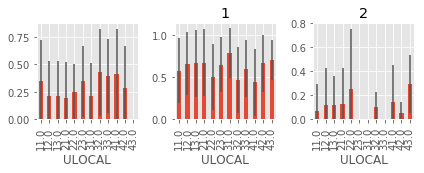

In [94]:
# Here's the distribution of urban proximity over the three topics:
fig1 = plt.figure()
chrt = 0
for num in topic_columns:
    chrt += 1 
    ax = fig1.add_subplot(2,3, chrt)
    grouped_urban[num].mean().plot(kind = 'bar', yerr = grouped_urban[num].std(), ylim=0, ax=ax, title=num)

fig1.tight_layout()
plt.show()

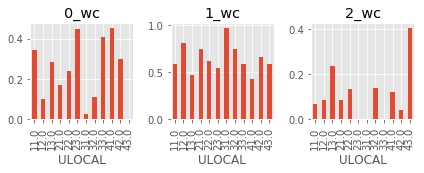

In [95]:
# Here's the distribution of each topic over words, for each urban category:
fig2 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig2.add_subplot(2,3, chrt)
    (grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum()).plot(kind = 'bar', ylim=0, ax=ax2, title=e)

fig2.tight_layout()
plt.show()